In [1]:

### Creating partially occluded point cloud. 
import mitsuba as mi
import numpy as np 
import roma
import torch
import drjit as dr
from matplotlib import pyplot as plt
import pyrender
import trimesh
import os 

os.environ['PYOPENGL_PLATFORM'] = 'egl'
mi.set_variant('cuda_ad_rgb')

def rotvec_to_matrix(axis, device='cuda'):
    """
    Rotate the point cloud to align its Y-axis with the given axis using PyTorch.
    
    Args:
        axis (torch.Tensor): Target axis to align with, should be of shape (3,).
        device (str): Device to perform the computation ('cpu' or 'cuda').
    Returns:
        torch.Tensor: Rotated point cloud of shape (N, 3).
    """
    ## TODO: make this batched, to rotate the point cloud to different configurations at once. 
    # Normalize the axis
    axis = axis / torch.linalg.norm(axis)
    z_axis = torch.tensor([0., 1., 0.], device='cuda')
    rotation_vector = torch.cross(z_axis, axis)
    angle = torch.arccos(torch.dot(z_axis, axis))
    
    # Convert rotation vector and angle to a PyTorch tensor
    rotation_vector = torch.tensor(rotation_vector, dtype=torch.float32, device=device)
    angle = torch.tensor(angle, dtype=torch.float32, device=device)
    
    # Create the rotation matrix using torch-roma
    rotation_matrix = roma.rotvec_to_rotmat(rotation_vector * angle)
    return rotation_matrix

def get_posed_split_cylinder_mesh(radius, height, axis, burial_percent = 0.5):
    """Args
    radius (float)
    height (float)
    axis (np.array (3,))
    burial_percent : what percentage of the visible cylinder from origin should be buried / visible
    """
    # Generate Cylinder Mesh and align it's axis with Y axis
    capped_cylinder = trimesh.creation.cylinder(radius=radius, height=height, sections=64, cap=True)
    capped_cylinder.apply_transform(trimesh.transformations.rotation_matrix(angle=np.pi/2, direction=[1, 0, 0]))
    
    # Compute Rotation matrix to rotate cylinder to given axis
    axis = torch.from_numpy(axis).float().cuda()
    axis = axis / torch.linalg.norm(axis)
    rotmat = rotvec_to_matrix(axis).cpu().numpy()
    pose = np.eye(4)
    pose[:3,:3] = rotmat
    capped_cylinder.apply_transform(pose)
    
    #Compute Burial offset and bury cylinder by that much.
    yrange = (capped_cylinder.vertices[:,1].max() - capped_cylinder.vertices[:,1].min())/2
    burial_offset = burial_percent * yrange
    relative_burial = burial_offset / height 
    pose = np.eye(4)
    pose[1,3] = burial_offset
    capped_cylinder.apply_transform(pose)
    
    # Split the mesh based on burial 
    plane_normal = np.array([0., 1., 0.0])
    plane_point = np.array([0., 0., 0.])
    
    # Perform the split
    sliced_cylinder = capped_cylinder.slice_plane(plane_normal=plane_normal, plane_origin=plane_point)
    return sliced_cylinder 

def get_KRT(fov=np.pi/3, HW=[400,400], cam_origin=[5.0, 0.0, 0.0]):
    """ Compute K matrix and camera pose from mitsuba3 scene. Returns torch.tensor K (3x3), and RT [4x4]"""
    H, W = HW 
    fx = W / (2 * np.tan(fov/2))
    fy = fx
    cx, cy = W/2, H/2
    K = torch.tensor([[fx, 0.0, cx], [0.0, fy, cy], [0.0, 0.0, 1.0]]).float().cuda()
    RT = mi.Transform4f.look_at(origin=cam_origin, target=(1.1*np.array(cam_origin)).tolist(), up=[0.0, 1.0, 0.0]).matrix.numpy()[0]
    RT = RT
    return K, RT

def pyrender_depth(HW, cyl_mesh, fov, cam_origin):
    """ takes a cylinder mesh posed and centered at origin, location of camera, fov, image size
    and returns depth, K, RT """
    mesh = pyrender.Mesh.from_trimesh(cyl_mesh)
    scene = pyrender.Scene()
    scene.add(mesh)
    camera = pyrender.PerspectiveCamera(yfov=fov, aspectRatio=HW[1]/HW[0])
    K, RT = get_KRT(fov, HW, cam_origin)
    
    scene.add(camera, pose=RT)
    light = pyrender.SpotLight(color=np.ones(3), intensity=0.5,
                            innerConeAngle=np.pi/16.0,
                            outerConeAngle=np.pi/6.0)
    scene.add(light, pose=RT)
    r = pyrender.OffscreenRenderer(HW[0], HW[1])
    color, depth = r.render(scene)
    return torch.from_numpy(depth).float().cuda(), K, torch.from_numpy(RT).float().cuda()

def pc_from_depth(depthmap, K, cam2world=torch.eye(4).cuda()):
    """ Compute point cloud in the world frame from depthmap and K matrix 
    Args:
		depthmap (torch.tensor) M,N
		K (torch.tensor) [3,3]
		cam2world (torch.tensor) [4,4] pose matrix that goes from camera to world 
    """
    fx, fy, cx, cy = K[0,0], K[1,1], K[0,2], K[1,2]
    height, width = depthmap.shape[:2]
    v, u = torch.meshgrid(torch.arange(width).cuda(), torch.arange(height).cuda(), indexing='ij')
    u = u.flatten()
    v = v.flatten()
    depth = depthmap.flatten()
    X = (u - cx) * depth / fx 
    Y = -(v - cy) * depth / fy
    Z = depth
    idx = depth > 0
    points = torch.stack([X[idx], Y[idx], -Z[idx]], dim=-1).reshape(-1,3)
    points = points@cam2world[:3,:3].T + cam2world[:3, 3:].T
    return points

[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!


/tmp/ipykernel_3931085/3387795097.py:33: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_3931085/3387795097.py:34: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



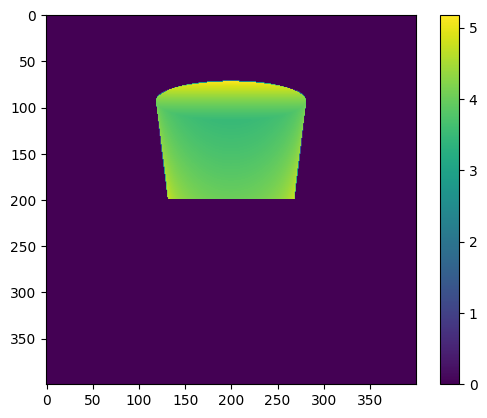

In [9]:
axis = np.array([0., 0.5, 0.5])
fov = np.pi/3
HW = [400,400]
radius = 1.0 
height = 2.5
cam_origin = [0.0, 0.0,5.0]

    
# cyl_mesh = get_posed_cylinder_mesh(radius, height, axis, -1.5)
cyl_mesh = get_posed_split_cylinder_mesh(radius, height, axis, 0.2)
depth, K, RT = pyrender_depth(HW, cyl_mesh, fov, cam_origin)
points = pc_from_depth(depth, K, RT)
plt.figure()
plt.imshow(depth.cpu().numpy(), cmap=plt.cm.viridis)
plt.colorbar()

In [10]:
import plotly.graph_objects as go
import numpy as np
from barrelnet.pointnet.data import normalize_pc


# Generate some random 3D data points
np.random.seed(0)
points_np =  points.cpu().numpy()
x, y, z = points_np[:,0], points_np[:,1], points_np[:,2]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=1,
        color=z,                # Set color to the z values
        colorscale='Viridis',   # Choose a colorscale
        opacity=1.0
    )
)])

# Set the layout
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    title='3D Point Cloud',
    showlegend=False
)

# Show the plot
fig.show()